In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import mlflow
import dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir)), 'src')
sys.path.append(MODULE_DIR)

try:
    PLOT_BASE_DIR = os.path.abspath(os.environ["PLOT_BASE_DIR"])
except KeyError:
    raise RuntimeError("Missing plot output dir. Set the PLOT_BASE_DIR variable accordingly")
os.makedirs(PLOT_BASE_DIR, exist_ok=True)


In [5]:
# Load data
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("paper_rotations_eurosat")

token = None
run_records = []
while True:
    runs = client.search_runs(experiment.experiment_id, page_token=token)
    token = runs.token
    for run in runs:
        run_dict = {
            "id": run.info.run_id,
            "status": run.info.status,
        }
        run_dict.update(run.data.params)
        run_dict.update(run.data.metrics)
        run_dict.update({
            f"tags.{tag}": value for tag, value in run.data.tags.items()
        })
        run_records.append(run_dict)

    if token is None:
        break

df_runs = pd.DataFrame.from_records(run_records)

assert (df_runs["seed"].astype(int) == 1).all()

df_runs_noninterp = df_runs[df_runs.train_accuracy < 1]
if len(df_runs_noninterp) > 0:
    df_runs_noninterp = df_runs_noninterp[
        ["id", "network_builder_widen_factor", "num_train_rotations", "noise_fraction", "training_seed", "train_accuracy", "train_loss"]
    ]
    print(f"Found non-interpolating runs:\n{df_runs_noninterp}")
df_runs = df_runs[df_runs.train_accuracy == 1.0]

df_runs_fail = df_runs[(df_runs.status != "FINISHED")]
if len(df_runs_fail) > 0:
    df_runs_fail = df_runs_fail[
        ["id", "network_builder_widen_factor", "num_train_rotations", "noise_fraction", "training_seed", "train_accuracy", "train_loss"]
    ]
    print(f"Found failed runs:\n{df_runs_fail}")
df_runs = df_runs[df_runs.status == "FINISHED"]

assert (df_runs.status == "FINISHED").all()
assert (df_runs.train_accuracy == 1.0).all()

print(f"Have a total of {len(df_runs)} runs")

COLUMNS_SETTING = [
    "network_builder_widen_factor", "noise_fraction", "num_train_rotations"
]
COLUMNS_METRICS = [
    "best_final_test_accuracy_diff", "best_test_accuracy", "test_accuracy_random",
    "train_accuracy", "train_loss"
]
COLUMNS = COLUMNS_SETTING + COLUMNS_METRICS

df_runs = df_runs.set_index("id")
df_runs_full = df_runs
df_runs = df_runs[COLUMNS]

df_runs.num_train_rotations = df_runs.num_train_rotations.astype(int)
df_runs.network_builder_widen_factor = df_runs.network_builder_widen_factor.astype(int)

# Load early-stopped train accuracy for all runs
early_stopped_accuracies = {}
early_stopped_noise_accuracies = {}
early_stopping_epochs = {}
for idx, run_id in enumerate(df_runs.index):
    best_test_accuracy = max(client.get_metric_history(run_id, key="test_accuracy_random"), key=lambda metric: metric.value)
    best_epoch = best_test_accuracy.step
    early_stopping_epochs[run_id] = best_epoch
    train_accuracies = client.get_metric_history(run_id, key="train_accuracy")
    early_stopped_train_accuracy, = filter(lambda metric: metric.step == best_epoch, train_accuracies)
    early_stopped_accuracies[run_id] = early_stopped_train_accuracy.value

    if df_runs.loc[run_id]["noise_fraction"] == "0.2":
        train_noise_accuracies = client.get_metric_history(run_id, key="train_noise_accuracy")
        early_stopped_noise_accuracy, = filter(lambda metric: metric.step == best_epoch, train_noise_accuracies)
        early_stopped_noise_accuracies[run_id] = early_stopped_noise_accuracy.value
    else:
        early_stopped_noise_accuracies[run_id] = 0.0

    if (idx + 1) % 1000 == 0 or (idx + 1) == len(df_runs):
        print(f"Processed {idx + 1}/{len(df_runs)} runs")

df_runs["es_train_accuracy"] = pd.Series(early_stopped_accuracies)
df_runs["es_train_noise_accuracy"] = pd.Series(early_stopped_noise_accuracies)
df_runs["es_train_noiseless_accuracy"] = (
    df_runs["es_train_accuracy"] - df_runs["noise_fraction"].astype(float) * df_runs["es_train_noise_accuracy"]
) / (1.0 - df_runs["noise_fraction"].astype(float))
df_runs["es_train_epoch"] = pd.Series(early_stopping_epochs)


Found non-interpolating runs:
                                  id network_builder_widen_factor  \
44  b2ed21bca50c498cb96cb929166421cb                            6   

   num_train_rotations noise_fraction training_seed  train_accuracy  \
44                   8            0.2             2        0.999967   

    train_loss  
44    0.000077  
Have a total of 99 runs


/tmp/ipykernel_24325/588456994.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs.num_train_rotations = df_runs.num_train_rotations.astype(int)
/tmp/ipykernel_24325/588456994.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs.network_builder_widen_factor = df_runs.network_builder_widen_factor.astype(int)


Processed 99/99 runs


/tmp/ipykernel_24325/588456994.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs["es_train_accuracy"] = pd.Series(early_stopped_accuracies)
/tmp/ipykernel_24325/588456994.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runs["es_train_noise_accuracy"] = pd.Series(early_stopped_noise_accuracies)
/tmp/ipykernel_24325/588456994.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [6]:
import plot_util
plot_util.setup_matplotlib()

In [7]:
NOISE_ES_STYLE_MAP = {
    "0.0": {"int": ("C0", plot_util.LINESTYLE_MAP[1]), "es": ("C1", plot_util.LINESTYLE_MAP[1])},
    "0.2": {"int": ("C0", plot_util.LINESTYLE_MAP[0]), "es": ("C1", plot_util.LINESTYLE_MAP[0])},
}

ABLATION_NOISE_STYLE_MAP = {
    "0.0": [(f"C{idx}", plot_util.LINESTYLE_MAP[1]) for idx in range(5)],
    "0.2": [(f"C{idx}", plot_util.LINESTYLE_MAP[0]) for idx in range(5)],
}

ABLATION_MODEL_STYLE_MAP = {
    "int": [(f"C{idx}", plot_util.LINESTYLE_MAP[0]) for idx in range(5)],
    "es": [(f"C{idx}", plot_util.LINESTYLE_MAP[1]) for idx in range(5)],
}

MAX_ROT = 12

## Test error curve

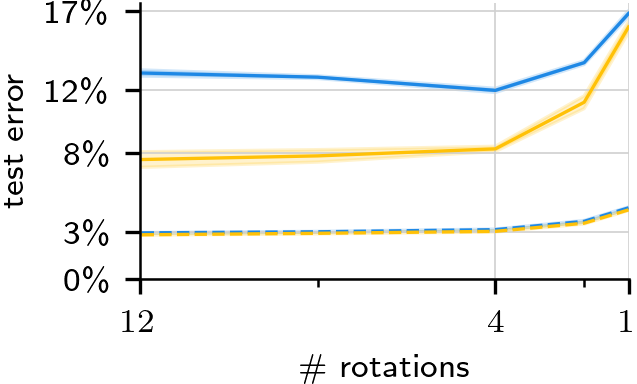

In [8]:
fig, ax = plt.subplots(
    figsize=(plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5] / plot_util.GOLDEN_RATIO)
)

df_test_error = df_runs[df_runs.network_builder_widen_factor == 6].drop(
    "network_builder_widen_factor", axis=1
).groupby(["noise_fraction", "num_train_rotations"]).agg(["mean", "sem"])
for noise_idx, noise_fraction in enumerate(df_test_error.index.get_level_values(0).unique()):
    df_setting_noise = df_test_error.loc[noise_fraction]
    num_train_rotations = df_setting_noise.index
    xs = num_train_rotations
    ys_mean = 1.0 - df_setting_noise["test_accuracy_random"]["mean"]
    ys_err = df_setting_noise["test_accuracy_random"]["sem"]
    current_color, current_ls = NOISE_ES_STYLE_MAP[noise_fraction]["int"]
    ax.fill_between(
        xs,
        ys_mean - ys_err,
        ys_mean + ys_err,
        color=current_color,
        alpha=0.2,
    )
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"{float(noise_fraction)*100:.0f}\% noise",
        ls=current_ls,
    )

    ys_mean = 1.0 - df_setting_noise["best_test_accuracy"]["mean"]
    ys_err = df_setting_noise["best_test_accuracy"]["sem"]
    current_color, current_ls = NOISE_ES_STYLE_MAP[noise_fraction]["es"]
    ax.fill_between(
        xs,
        ys_mean - ys_err,
        ys_mean + ys_err,
        color=current_color,
        alpha=0.2,
    )
    ax.plot(
        xs, ys_mean,
        c=current_color,
        label=f"{float(noise_fraction)*100:.0f}\% noise",
        ls=current_ls,
    )

ax.set_ylim(0.0, 0.175)
ax.set_yticks((
    0.0,
    0.03,
    0.08,
    0.12,
    0.17,
))
ax.set_ylabel("test error")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))

ax.set_xlim(1, MAX_ROT)
ax.set_xticks((1, 4, MAX_ROT))
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(df_runs.num_train_rotations.unique()))
ax.invert_xaxis()
ax.set_xlabel(r"\# rotations")

plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, "rotations_error.pdf"))

plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()
handles = [proxy_patch, proxy_patch] + handles
labels = ["interpolating:", "opt.\ early-stopped:"] + labels

legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[2],
))

legend_fig.legend(
    handles,
    labels,
    loc='center right',
    ncol=3,
    frameon=False,
    borderpad=0.5,
    # handletextpad=0.3,
    columnspacing=1.0,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, "rotations_error_legend.pdf"))

plt.close(legend_fig)


## Early-stopped train error curves

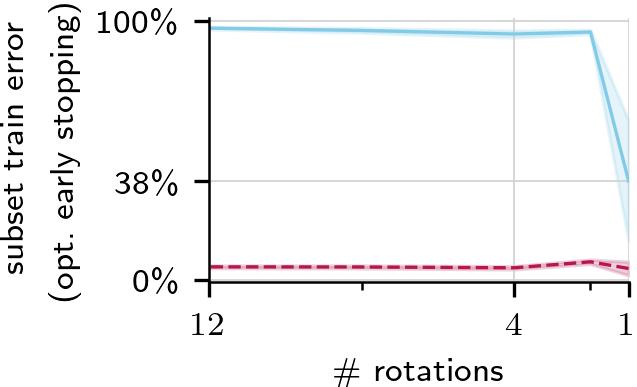

In [9]:
fig, ax = plt.subplots(
    figsize=(
        plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[5] / plot_util.GOLDEN_RATIO
    )
)

df_es_train_error = df_runs[df_runs.network_builder_widen_factor == 6].drop(
    "network_builder_widen_factor", axis=1
).groupby(["noise_fraction", "num_train_rotations"]).agg(["mean", "sem"])
for noise_idx, noise_fraction in enumerate(df_es_train_error.index.get_level_values(0).unique()):
    if noise_fraction == "0.0":
        continue

    df_setting_noise = df_es_train_error.loc[noise_fraction]
    num_train_rotations = df_setting_noise.index
    xs = num_train_rotations
    ys_mean = 1.0 - df_setting_noise["es_train_noise_accuracy"]["mean"]
    ys_err = df_setting_noise["es_train_noise_accuracy"]["sem"]
    current_color = "C3"
    _, current_ls = NOISE_ES_STYLE_MAP["0.2"]["es"]
    ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"noisy subset",
        ls=current_ls,
    )

    ys_mean = 1.0 - df_setting_noise["es_train_noiseless_accuracy"]["mean"]
    ys_err = df_setting_noise["es_train_noiseless_accuracy"]["sem"]
    current_color = "C2"
    _, current_ls = NOISE_ES_STYLE_MAP["0.0"]["es"]
    ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"clean subset",
        ls=current_ls,
    )


ax.set_ylim(0.0 - 1e-2, 1.0 + 1e-2)
ax.set_yticks((
    0.0,
    0.38,
    1.0
))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))
ax.set_ylabel(r"\noindent{}\;\;\;subset train error \\(opt.\ early stopping)")

ax.set_xlim(1, MAX_ROT)
ax.set_xticks((1, 4, MAX_ROT))
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(df_runs.num_train_rotations.unique()))
ax.invert_xaxis()
ax.set_xlabel(r"\# rotations")

plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, "rotations_es.pdf"))

plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()
handles = [proxy_patch, handles[0], proxy_patch, handles[1]]
labels = ["", labels[0], "", labels[1]]

legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[2],
))

legend_fig.legend(
    handles,
    labels,
    loc='center',
    ncol=2,
    frameon=False,
    borderpad=0.5,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, "rotations_es_legend.pdf"))

plt.close(legend_fig)


## Difference to double descent

In [10]:
diff_xrange = (1, MAX_ROT)
diff_xticks = (1, 4, 12)
diff_xticks_minor = (1, 2, 4, 12)


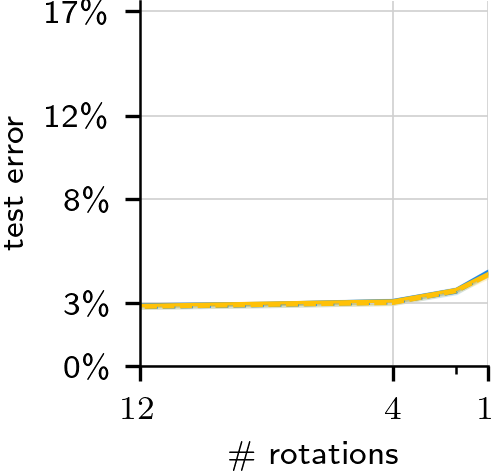

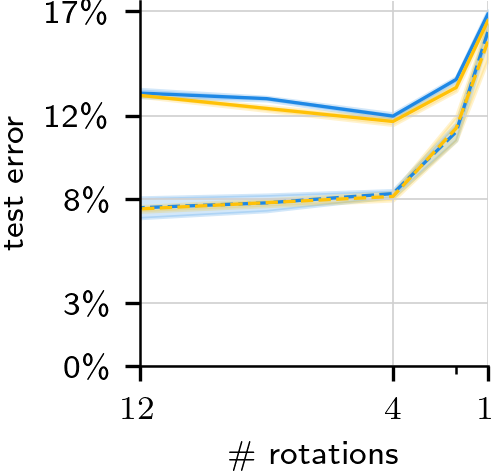

In [11]:
for noise_fraction, noise_label in {"0.0": "_noiseless", "0.2": ""}.items():
    fig, ax = plt.subplots(
        figsize=(plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6] / plot_util.GOLDEN_RATIO)
    )

    df_ablation_error = df_runs[df_runs.noise_fraction == noise_fraction].drop("noise_fraction", axis=1).groupby(
        ["network_builder_widen_factor", "num_train_rotations"]
    ).agg(["mean", "sem"])
    for width_idx, width in enumerate(df_ablation_error.index.get_level_values(0).unique()):
        df_setting_width = df_ablation_error.loc[width]
        num_rotations = df_setting_width.index
        xs = num_rotations

        ys_mean = 1.0 - df_setting_width["test_accuracy_random"]["mean"]
        ys_err = df_setting_width["test_accuracy_random"]["sem"]
        current_color, current_ls = ABLATION_MODEL_STYLE_MAP["int"][width_idx]
        ax.fill_between(
            xs,
            ys_mean - ys_err,
            ys_mean + ys_err,
            color=current_color,
            alpha=0.2,
        )
        ax.plot(
            xs,
            ys_mean,
            c=current_color,
            label=fr"WRN16-{width}",
            ls=current_ls,
        )

        ys_mean = 1.0 - df_setting_width["best_test_accuracy"]["mean"]
        ys_err = df_setting_width["best_test_accuracy"]["sem"]
        current_color, current_ls = ABLATION_MODEL_STYLE_MAP["es"][width_idx]
        ax.fill_between(
            xs,
            ys_mean - ys_err,
            ys_mean + ys_err,
            color=current_color,
            alpha=0.2,
        )
        ax.plot(
            xs, ys_mean,
            c=current_color,
            label=fr"WRN16-{width}",
            ls=current_ls,
        )

    ax.set_ylim(0.0, 0.175)
    ax.set_yticks((
        0.0,
        0.03,
        0.08,
        0.12,
        0.17,
    ))
    ax.set_ylabel("test error")
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))

    ax.set_xlim(*diff_xrange)
    ax.set_xticks(diff_xticks)
    ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(diff_xticks_minor))
    ax.invert_xaxis()
    ax.set_xlabel(r"\# rotations")

    plt.show()

    fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_rotations{noise_label}_error.pdf"))

    plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()

handles = [proxy_patch, proxy_patch] + handles
labels = ["interpolating:", "optimally early-stopped:"] + labels

legend_fig = plt.figure(figsize=(
    2 * plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[4],
))

legend_fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=3,
    frameon=False,
    borderpad=0.5,
    handletextpad=0.5,
    columnspacing=0.8,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_rotations_error_legend.pdf"))

plt.close(legend_fig)


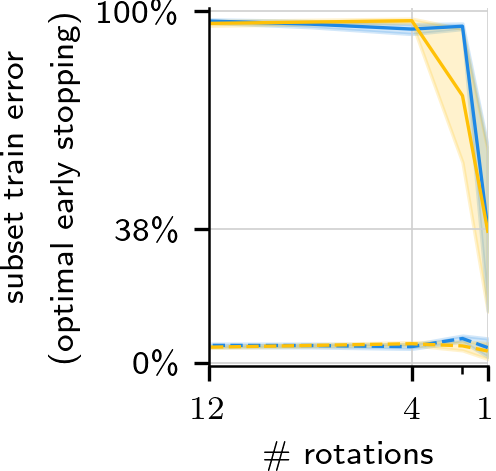

In [12]:
fig, ax = plt.subplots(
    figsize=(
        plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6] / plot_util.GOLDEN_RATIO
    )
)

df_ablation_es = df_runs[df_runs.noise_fraction == "0.2"].drop("noise_fraction", axis=1).groupby(
    ["network_builder_widen_factor", "num_train_rotations"]
).agg(["mean", "sem"])
for width_idx, width in enumerate(df_ablation_es.index.get_level_values(0).unique()):
    df_setting_width = df_ablation_es.loc[width]
    num_rotations = df_setting_width.index
    xs = num_rotations

    ys_mean = 1.0 - df_setting_width["es_train_noise_accuracy"]["mean"]
    ys_err = df_setting_width["es_train_noise_accuracy"]["sem"]
    current_color, current_ls = ABLATION_MODEL_STYLE_MAP["int"][width_idx]
    ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"WRN16-{width}",
        ls=current_ls,
    )

    ys_mean = 1.0 - df_setting_width["es_train_noiseless_accuracy"]["mean"]
    ys_err = df_setting_width["es_train_noiseless_accuracy"]["sem"]
    current_color, current_ls = ABLATION_MODEL_STYLE_MAP["es"][width_idx]
    ax.fill_between(xs, ys_mean - ys_err, ys_mean + ys_err, color=current_color, alpha=0.2)
    ax.plot(
        xs,
        ys_mean,
        c=current_color,
        label=fr"WRN16-{width}",
        ls=current_ls,
    )

ax.set_ylim(0.0 - 1e-2, 1.0 + 1e-2)
ax.set_yticks((
    0.0,
    0.38,
    1.0
))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1.0, decimals=0))
ax.set_ylabel(r"subset train error \\(optimal early stopping)")

ax.set_xlim(*diff_xrange)
ax.set_xticks(diff_xticks)
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(diff_xticks_minor))
ax.invert_xaxis()
ax.set_xlabel(r"\# rotations")

plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_rotations_es.pdf"))

plt.close(fig)

# Legend
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()

handles = [proxy_patch, handles[0], proxy_patch, handles[1], proxy_patch, handles[2], proxy_patch, handles[3]]
labels = ["noisy subset:", labels[0], "clean subset:", labels[1], "", labels[2], "", labels[3]]

legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[4],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[4],
))

legend_fig.legend(
    handles,
    labels,
    loc='lower right',
    ncol=2,
    frameon=False,
    borderpad=0.5,
    handletextpad=0.4,
    columnspacing=0.7,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, f"ablation_rotations_es_legend.pdf"))

plt.close(legend_fig)


## Training loss

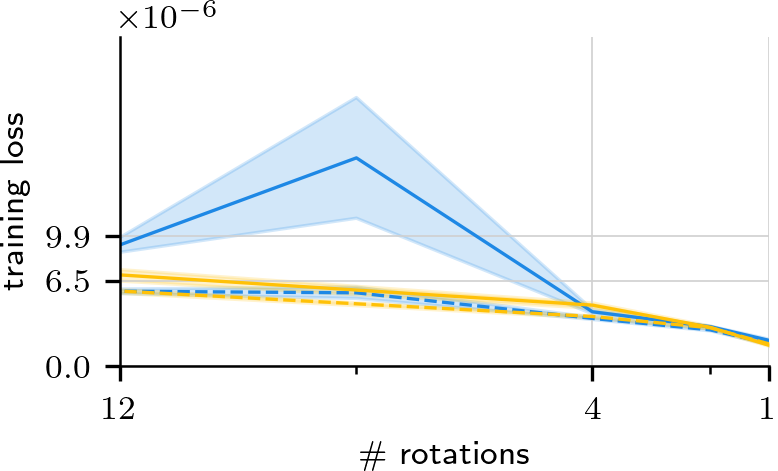

In [13]:
fig, ax = plt.subplots(
    figsize=(plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6], plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6] / plot_util.GOLDEN_RATIO)
)

for width_idx, widen_factor in enumerate((6, 12)):
    df_loss = df_runs.loc[df_runs.network_builder_widen_factor == widen_factor].drop(
        "network_builder_widen_factor", axis=1
    ).groupby(["noise_fraction", "num_train_rotations"]).agg(["mean", "sem"])
    for noise_idx, noise_fraction in enumerate(df_test_error.index.get_level_values(0).unique()):
        df_setting_noise = df_loss.loc[noise_fraction]
        num_train_rotations = df_setting_noise.index
        xs = num_train_rotations
        ys_mean = df_setting_noise["train_loss"]["mean"]
        ys_err = df_setting_noise["train_loss"]["sem"]
        current_color, current_ls = ABLATION_NOISE_STYLE_MAP[noise_fraction][width_idx]
        ax.fill_between(
            xs,
            ys_mean - ys_err,
            ys_mean + ys_err,
            color=current_color,
            alpha=0.2,
        )
        ax.plot(
            xs,
            ys_mean,
            c=current_color,
            label=fr"WRN16-{widen_factor}",
            ls=current_ls,
        )

ax.set_ylim(0.0, 2.5e-5)
ax.set_yticks((
    0.0,
    6.5e-6,
    9.9e-6,
))
ax.set_ylabel("training loss")

ax.set_xlim(1, MAX_ROT)
ax.set_xticks((1, 4, MAX_ROT))
ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(df_runs.num_train_rotations.unique()))
ax.invert_xaxis()
ax.set_xlabel(r"\# rotations")

plt.show()

fig.savefig(os.path.join(PLOT_BASE_DIR, "loss_rotations.pdf"))

plt.close(fig)

# Legend
legend_fig = plt.figure(figsize=(
    plot_util.FIGURE_WIDTH_FOR_COLUMNS_IN[6],
    plot_util.LEGEND_HEIGHT_FOR_ROWS_IN[4],
))
handles, labels = ax.get_legend_handles_labels()
proxy_patch = plot_util.proxy_patch()
handles = [proxy_patch, proxy_patch, proxy_patch, proxy_patch] + [val for handle in handles for val in (handle, proxy_patch)]
labels = [r"0\% noise:", "", "20\% noise:", ""] + [val for label in labels for val in (label, "")]
legend_fig.legend(
    handles,
    labels,
    loc='center right',
    ncol=3,
    frameon=False,
    borderpad=0.5,
)

legend_fig.savefig(os.path.join(PLOT_BASE_DIR, "loss_rotations_legend.pdf"))

plt.close(legend_fig)
